# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home diretcory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [1]:
import numpy as np
from glob import glob
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms
%matplotlib inline

# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 0 total human images.
There are 0 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

In [3]:
# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier(
    'haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[0])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x, y, w, h) in faces:
    # add bounding box to color image
    cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 0), 2)

# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [3]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
Of 100 samples from the human sample and dog sample respectively, we can find

Human faces: 96

Dog faces: 18

In [4]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#

## TODO: Test the performance of the face_detector algorithm
## on the images in human_files_short and dog_files_short.
total_face = 0
for face in human_files_short:
    if (face_detector(face)):
        total_face += 1
print('Human faces: {}'.format(total_face))

total_face = 0
for face in dog_files_short:
    if (face_detector(face)):
        total_face += 1
print('Dog faces: {}'.format(total_face))

Human faces: 96
Dog faces: 18


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [5]:
### (Optional)
### TODO: Test performance of anotherface detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [4]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [9]:
def VGG16_predict(img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''

    ## TODO: Complete the function.
    ## Load and pre-process an image from the given img_path
    ## Return the *index* of the predicted class for that image
    transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    if (use_cuda):
        device = 'cuda'
    else:
        device = 'cpu'
    img = Image.open(img_path)
    img = img.convert('RGB')
    img = transform(img)

    model_input = img.unsqueeze(0)

    VGG16.eval()  # eval mode
    VGG16.to(device)
    model_input = model_input.to(device)

    # get sample outputs
    output = VGG16(model_input)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy()) if not use_cuda else np.squeeze(
        preds_tensor.cpu().numpy())

    del model_input, output
    torch.cuda.empty_cache()

    return preds


file = './images/Labrador_retriever_06449.jpg'
print(VGG16_predict(file))

208


### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    ## TODO: Complete the function.
    pred = VGG16_predict(img_path)
    if (pred > 150 and pred < 269):
        return True
    else:
        return False
    return None  # true/false

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 

Dog faces in human file: 0

Dog faces in dog file: 94


In [11]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
total_face = 0
for face in human_files_short:
    if (dog_detector(face)):
        total_face += 1
print('Dog faces in human file: {}'.format(total_face))

total_face = 0
for face in dog_files_short:
    if (dog_detector(face)):
        total_face += 1
print('Dog faces in dog file: {}'.format(total_face))

Dog faces in human file: 0
Dog faces in dog file: 94


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [12]:
### (Optional)
### TODO: Report the performance of another pre-trained network.
### Feel free to use as many code cells as needed.
VGG16 = VGG16.to('cpu')

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [13]:
import os
import torch
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# check if CUDA is available
use_cuda = torch.cuda.is_available()
print('Use CUDA: {}'.format(use_cuda))
#use_cuda=False

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# ImageFile.LOAD_TRUNCATED_IMAGES = True

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),  # randomly flip and rotate
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

test_transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

# choose the training and test datasets
train_data = datasets.ImageFolder('dogImages/train', transform=transform)
test_data = datasets.ImageFolder('dogImages/test', transform=test_transform)
valid_data = datasets.ImageFolder('dogImages/valid', transform=transform)

# obtain training indices that will be used for validation

train_idx = list(range(len(train_data)))
valid_idx = list(range(len(valid_data)))
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
    #sampler=train_sampler,
    num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(
    valid_data,
    batch_size=batch_size,
    shuffle=True,
    #sampler=valid_sampler,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)

loaders_scratch = {
    "train": train_loader,
    "valid": valid_loader,
    "test": test_loader
}

Use CUDA: True


In [14]:
# helper function to un-normalize and display an image
def imshow(img):
    """ Display a numpy-array as an image. """

    img = img.squeeze()
    img = img.transpose(1, 2, 0)
    img = img * np.array((0.229, 0.224, 0.225)) + np.array(
        (0.485, 0.456, 0.406))
    img = img.clip(0, 1)
    plt.imshow(img)

    #img = img / 2 + 0.5  # unnormalize
    #plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

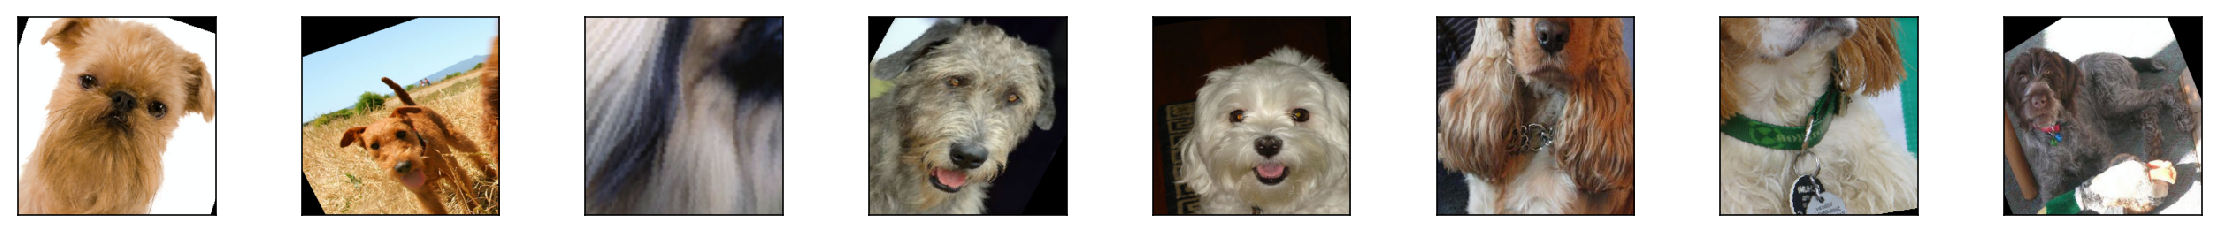

In [15]:
# obtain one batch of training images
dataiter = iter(valid_loader)

images, labels = dataiter.next()
images = images.numpy()  # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(8):
    ax = fig.add_subplot(2, 20 / 2, idx + 1, xticks=[], yticks=[])
    imshow(images[idx])
    #ax.set_title(classes[labels[idx]])

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


**Answer**: For the training and validation, I did some augumentation to the data to get more training out of the train and validation data incl. a better understanding of it. The augumentation is, randomrotation up to 30 degrees and random resize(incl. strech) clip down to 224 from any part of the picture. Also, I receive randomflips of the picture on the horisontal axis. When testing the outcome I used resizing down to 225 and then clipping it down to 224. No augumentation was down as I wanted to preserve the test data as close to the original as possible. 

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [16]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

typeOfDogs = 133


# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 224x224x3 image tensor)
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2))
        #sees 112*112*16
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2))
        #sees 56*56*32
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=2, stride=2))
        #sees 28*28*64
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        #sees 14*14*128
        self.fc1 = nn.Linear(128 * 14 * 14, 1024)
        self.fc2 = nn.Linear(1024, typeOfDogs)

        self.dropout = nn.Dropout(0.2)
        self.conv_drop = nn.Dropout2d()

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        out = self.layer1(x)
        out = self.conv_drop(out)
        out = self.layer2(out)
        out = self.conv_drop(out)
        out = self.layer3(out)
        out = self.conv_drop(out)
        out = self.layer4(out)
        out = self.conv_drop(out)
        # flatten image input
        #y = out.detach().size()
        #print(y)
        out = out.view(out.size()[0], -1)
        out = F.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        #out = F.log_softmax(self.fc3(out),dim=1)
        #out = self.fc3(out)
        return out


#-#-# You so NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ I applied four conv-layers consisting of the sequence (Conv2d, BatchNorm2d, RELU and Maxpool). I wanted to extract as many spatial features as possible for the two fully connected layer to optimize on. By shrinking the Linear layers down to size of the label, I made sure only important information would be captured. I also, introduced dropouts on almost all layers to make sure generalisation was obtained. Also, as CrossEntropyLoss was chosen no logsoftmax function was applied at the end of the architecture.

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [17]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion_scratch = nn.CrossEntropyLoss()
#criterion_scratch = nn.NLLLoss()
# specify optimizer
#optimizer_scratch = optim.Adagrad(model_scratch.parameters(), lr=0.0001, lr_decay=0.01, weight_decay=0.1, initial_accumulator_value=0)
optimizer_scratch = optim.Adam(
    model_scratch.parameters(),
    lr=0.000005,
    betas=(0.9, 0.999),
    eps=1e-08,
    weight_decay=0,
    amsgrad=False)
#sched = torch.optim.lr_scheduler.StepLR(optimizer_scratch, step_size=4,gamma=0.1)
#optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [18]:
checkpoint = torch.load('model_scratch.pt')
model_scratch.load_state_dict(checkpoint['state_dict'])
model_scratch.to('cuda')
#model_scratch.to('cpu')
#torch.cuda.empty_cache()

Net(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d

In [21]:
from PIL import Image, ImageFile
#GET RID OF "Image file truncated ERROR from PIL"
ImageFile.LOAD_TRUNCATED_IMAGES = True


def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    batch_idx = 0

    for epoch in range(1, n_epochs + 1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        correct = 0.0
        total = 0.00000001
                
        ###################
        # train the model #
        ###################
        model.train()
#        try:
            #print('train')
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            torch.set_grad_enabled(True)

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            train_loss = train_loss + (
                (1 / (batch_idx + 1)) * (loss.data - train_loss))
#        except Exception as e:
#            print('Except eval {} - batch_idx={}'.format(e, batch_idx))
#            if use_cuda:
#                torch.cuda.empty_cache()
        ######################
        # validate the model #
        ######################
#        if use_cuda:
#            torch.cuda.empty_cache()

        model.eval()
        try:
            #print('eval')
            for batch_idx, (data, target) in enumerate(loaders['valid']):
                # move to GPU
                if use_cuda:
                    data, target = data.cuda(), target.cuda()
                ## update the average validation loss
                torch.set_grad_enabled(False)

                # forward pass: compute predicted outputs by passing inputs to the model
                output = model(data)
                # calculate the batch loss
                loss = criterion(output, target)
                # update average validation loss
                valid_loss = valid_loss + (
                    (1 / (batch_idx + 1)) * (loss.data - valid_loss))
            pred = output.data.max(1, keepdim=True)[1]
            correct += np.sum(
                np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
            total += data.detach().size(0)

        except Exception as e:
            print('Except eval {} - batch_idx={}'.format(e, batch_idx))
            if use_cuda:
                torch.cuda.empty_cache()

        # print training/validation statistics
        print(
            'Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \tAccuracy: {:.1f}% ({}/{})'
            .format(epoch, train_loss, valid_loss, 100. * correct / total,
                    correct, total))
        
        #print('\nAccuracy: %2d%% (%2d/%2d)' % (100. * correct / total, correct, total))

        ## TODO: save the model if validation loss has decreased
        if ((epoch > 5) and (valid_loss <= valid_loss_min)):
            print(
                'Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'
                .format(valid_loss_min, valid_loss))
            torch.save({
                'epoch': epoch + 1,
                'arch': save_path,
                'state_dict': model.state_dict(),
                'valid_loss': valid_loss,
                'optimizer': optimizer.state_dict(),
            }, save_path)
            valid_loss_min = valid_loss
    # return trained model
    return model


#if use_cuda:
#    torch.cuda.empty_cache()
# train the model
#use_cuda=False

model_scratch = train(6, loaders_scratch, model_scratch, optimizer_scratch, criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
checkpoint = torch.load('model_scratch.pt')
model_scratch.load_state_dict(checkpoint['state_dict'])

Epoch: 1 	Training Loss: 4.211017 	Validation Loss: 4.305959 	Accuracy: 13.3% (2.0/15.00000001)
Epoch: 2 	Training Loss: 4.174603 	Validation Loss: 4.309951 	Accuracy: 0.0% (0.0/15.00000001)
Epoch: 3 	Training Loss: 4.197345 	Validation Loss: 4.346482 	Accuracy: 6.7% (1.0/15.00000001)
Epoch: 4 	Training Loss: 4.190758 	Validation Loss: 4.281088 	Accuracy: 20.0% (3.0/15.00000001)
Epoch: 5 	Training Loss: 4.181757 	Validation Loss: 4.245379 	Accuracy: 20.0% (3.0/15.00000001)
Epoch: 6 	Training Loss: 4.195891 	Validation Loss: 4.262326 	Accuracy: 0.0% (0.0/15.00000001)
Validation loss decreased (inf --> 4.262326).  Saving model ...


NOTE: I did not include all (>500 epochs) to reach the weightings used by the layers. Also, note the low learn rate needed to abtain any progress. A higher learn rate did not find any good local minimun at all near sufficient for 10% test accuracy. Some 6 epochs were used above to depict the training.

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [22]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss
        test_loss = test_loss + (
            (1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(
            np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)

    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (100. * correct / total,
                                                correct, total))


# call test function
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 4.009497


Test Accuracy: 11% (99/837)


In [23]:
#Offload everything
model_scratch = model_scratch.to('cpu')
torch.cuda.empty_cache()

---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [33]:
## TODO: Specify data loaders
transform = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),  # randomly flip and rotate
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# choose the training and test datasets
train_data = datasets.ImageFolder('./dogImages/train', transform=transform)
test_data = datasets.ImageFolder('./dogImages/test', transform=test_transform)
valid_data = datasets.ImageFolder('./dogImages/valid', transform=transform)

datasets = {"train": train_data, "valid": valid_data, "test": test_data}

# obtain training indices that will be used for validation

train_idx = list(range(len(train_data)))
valid_idx = list(range(len(valid_data)))
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    sampler=train_sampler,
    num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(
    valid_data,
    batch_size=batch_size,
    sampler=valid_sampler,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(
    test_data, batch_size=batch_size, num_workers=num_workers)

loaders_transfer = {
    "train": train_loader,
    "valid": valid_loader,
    "test": test_loader
}

### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [25]:
import torchvision.models as models
import torch.nn as nn
from collections import OrderedDict

## TODO: Specify model architecture
model_transfer = models.densenet201(pretrained=True)
# None
# Freeze parameters so we don't backprop through them
for param in model_transfer.parameters():
    param.requires_grad = False

# Switch to the classifier we need for the flower example
classifier = nn.Sequential(
    OrderedDict([
        ('fc1', nn.Linear(1920, 1024)),
        ('relu', nn.ReLU()),
        ('fc2', nn.Linear(1024, 512)),
        ('relu', nn.ReLU()),
        ('output', nn.Linear(512, typeOfDogs)),
        #('output', nn.LogSoftmax(dim=1))
    ]))

model_transfer.classifier = classifier

#print(model_transfer)

if use_cuda:
    model_transfer = model_transfer.to('cuda')

/opt/anaconda3/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ I reused the convolutional layers from the densenet201 model and substituted the fully connected classification layers with 3 layers forcing the width down by half in each step to eable relevant information to reach the output layer. Again as I used CrossEntropyLoss I did not have to include the Logsoftmax function. I did not use any dropout layers as I did not have to use many epochs to get good accuracy. As you can see I have in the notebook only pictured the optimasation by 6 epochs on both the model_scrath and the model_transfer models as I saved the models when reaching enough accuracy. And no, I did fully train the densenet to reach lowest validation loss as it was not needed to get above 60% accuracy for the test data.


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [26]:
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(
    model_transfer.parameters(), lr=0.0001, momentum=0.9)
#optimizer_transfer = optim.Adagrad(model_transfer.parameters(), lr=0.05, lr_decay=0.01, weight_decay=0, initial_accumulator_value=0)
#optimizer_transfer = optim.Adam(model_transfer.parameters(), lr=0.00050, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [27]:
# load the model that got the best validation accuracy
checkpoint = torch.load('model_transfer.pt')
model_transfer.load_state_dict(checkpoint['state_dict'])
model_transfer.to('cuda')
print('')

In [28]:
# train the model
model_transfer = train(6, loaders_transfer, model_transfer,
                       optimizer_transfer, criterion_transfer, use_cuda,
                       'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
checkpoint = torch.load('model_transfer.pt')
model_transfer.load_state_dict(checkpoint['state_dict'])

Epoch: 1 	Training Loss: 0.974797 	Validation Loss: 1.009107 	Accuracy: 73.3% (11.0/15.00000001)
Epoch: 2 	Training Loss: 0.969066 	Validation Loss: 0.889100 	Accuracy: 86.7% (13.0/15.00000001)
Epoch: 3 	Training Loss: 0.977906 	Validation Loss: 0.883535 	Accuracy: 66.7% (10.0/15.00000001)
Epoch: 4 	Training Loss: 0.976781 	Validation Loss: 0.872001 	Accuracy: 73.3% (11.0/15.00000001)
Epoch: 5 	Training Loss: 0.972434 	Validation Loss: 0.886794 	Accuracy: 80.0% (12.0/15.00000001)
Epoch: 6 	Training Loss: 0.967287 	Validation Loss: 0.852717 	Accuracy: 66.7% (10.0/15.00000001)
Validation loss decreased (inf --> 0.852717).  Saving model ...


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 60%.

In [29]:
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 0.493448


Test Accuracy: 86% (722/837)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [36]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

# list of class names by index, i.e. a name can be accessed like class_names[0]
#class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]


def predict_breed_transfer(img_path):
    # load the image and return the predicted breed

    class_names = [
        item[4:].replace("_", " ") for item in datasets['train'].classes
    ]

    img_pil = Image.open(img_path)
    #img = img.convert('RGB')
    #imgplot = plt.imshow(img_pil)
    #plt.show(img_pil)

    img_tensor = test_transform(img_pil)
    if (img_tensor.shape[0] == 4):
        img_pil = img_pil.convert('RGB')
        img_tensor = test_transform(img_pil)
    img_tensor.unsqueeze_(0)  #???? VGG! ResNet??
    img_variable = Variable(img_tensor, requires_grad=True)

    if (use_cuda):
        model = model_transfer.to('cpu')
    outputs = model_transfer(img_variable)
    #pred = outputs.data.max(1, keepdim=True)[1]
    prob, preds = torch.max(outputs, 1)
    return class_names[preds.numpy()[0]]

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `human_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [37]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.


def run_app(img_path):
    isDog = dog_detector(img_path)
    isHuman = face_detector(img_path)
    breed = ""

    breed = predict_breed_transfer(img_path)
    # Dog
    if isDog and not isHuman:
        breed = predict_breed_transfer(img_path)
        print("Hello dog and you're a", breed)

    # Human
    elif isHuman and not isDog:
        print("Hello, human!")
        breed = predict_breed_transfer(img_path)
        print("You look like a ... ")
        print(breed)

    else:
        print("ERROR, no prediction available")


img_path = "./images/Welsh_springer_spaniel_08203.jpg"
img = Image.open(img_path)
run_app(img_path)

Hello dog and you're a Welsh springer spaniel


---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ 

1.) First I should skip using the dog_dectector and face_detector as they are not accurate enough and have another logic - not clue yet wat to use... Perhaps the openface-library to capture faces? And use the pretrained model directly on the picture also.

2.) Then I should continue to improve on the pretrained model to reach a "true" good minimun

3.) Also, I need to think about a good exception strategy for pictures not capturing any dogs or humans - they could still contain valid dogs or humans but not trained on.

4.) Better and more training data. Pictures need to capture many real views of the classified dog, not only augumented ones. 

5.) Hyperparameter optimisation. Perhaps use scikit for that?

Looking at the results below, we see mixed results. Wolfs are not trained on although they would possibly be classified as/mistaken for Norwegian elkhound apart from the caracteristic curled tail. Also, a Norwegian Elkhound was not classified correctly which is strange. In addition, a low res picture of youe American Staffordshire Terrier got mislabelled. The cats got at least not labelled as dogs!




NEW IMAGE 


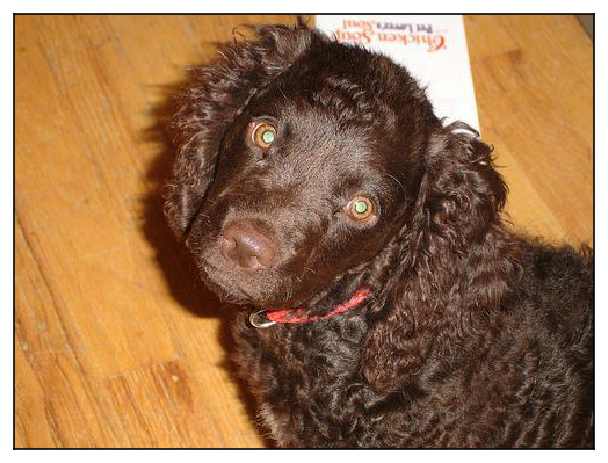

Hello dog and you're a American water spaniel



NEW IMAGE 


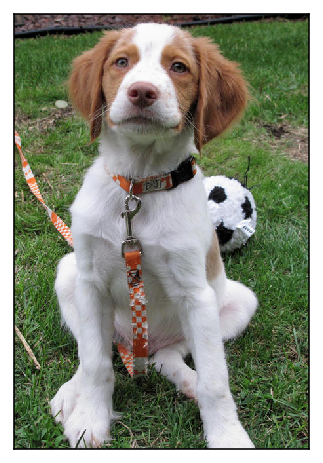

Hello dog and you're a Brittany



NEW IMAGE 


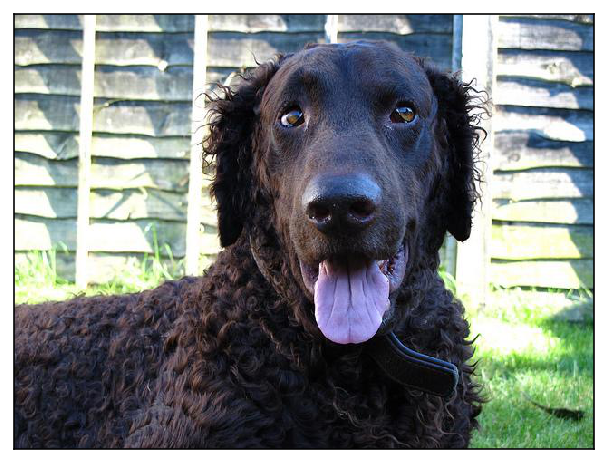

Hello dog and you're a Curly-coated retriever



NEW IMAGE 


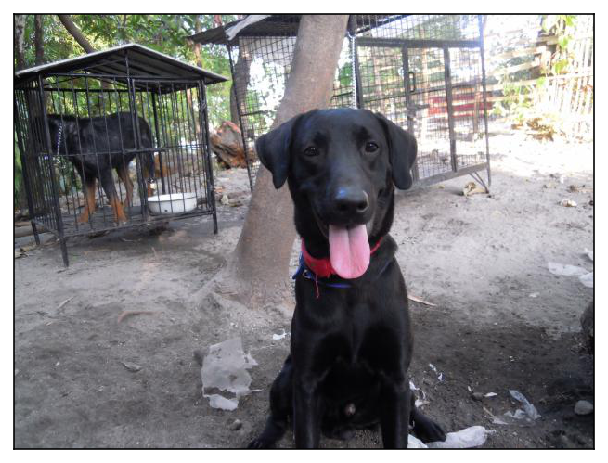

Hello dog and you're a Labrador retriever



NEW IMAGE 


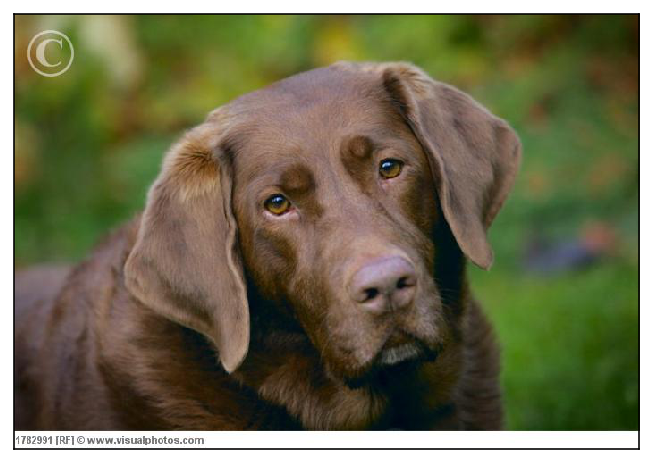

Hello dog and you're a Chesapeake bay retriever



NEW IMAGE 


Hello dog and you're a Labrador retriever



NEW IMAGE 


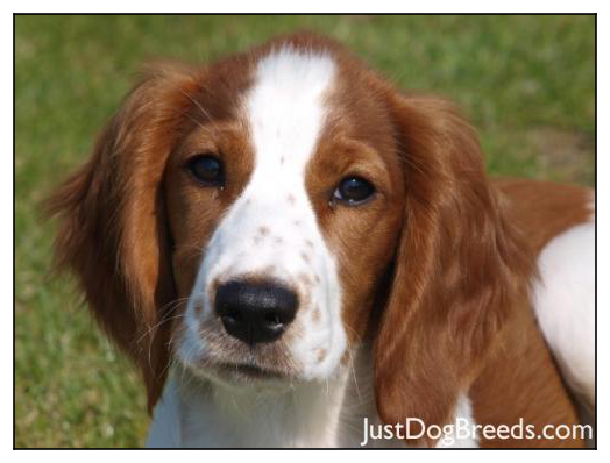

Hello dog and you're a Welsh springer spaniel



NEW IMAGE 


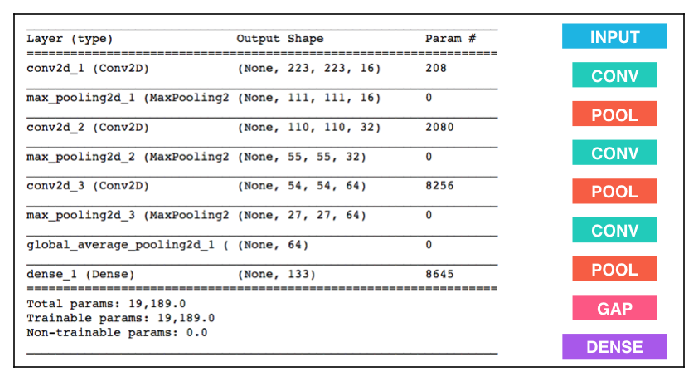

ERROR, no prediction available



NEW IMAGE 


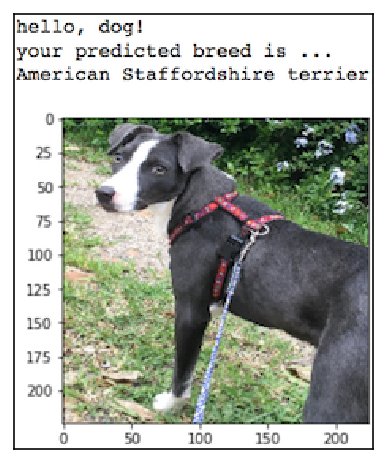

Hello dog and you're a Entlebucher mountain dog



NEW IMAGE 


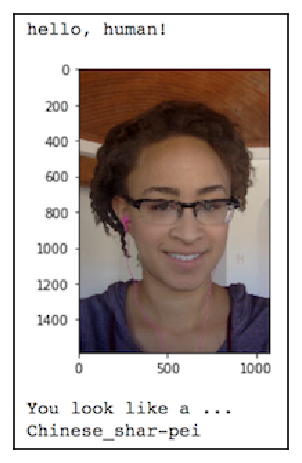

Hello, human!
You look like a ... 
Xoloitzcuintli



NEW IMAGE 


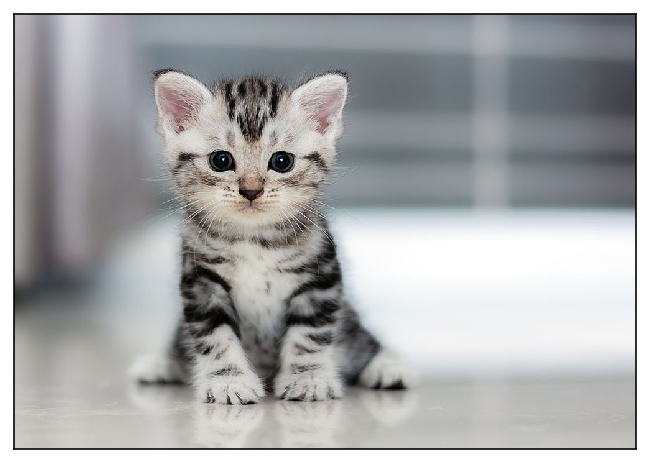

ERROR, no prediction available



NEW IMAGE 


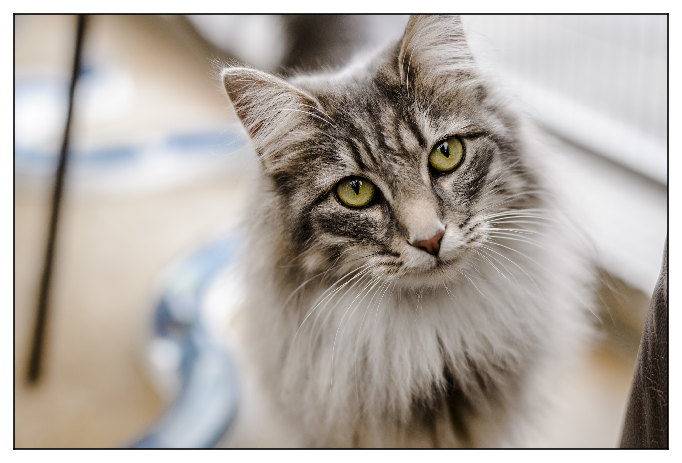

Hello, human!
You look like a ... 
Lowchen



NEW IMAGE 


Hello, human!
You look like a ... 
Golden retriever



NEW IMAGE 


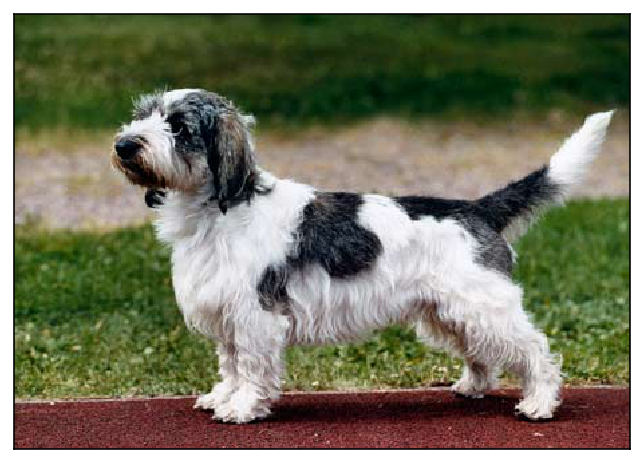

Hello dog and you're a Petit basset griffon vendeen



NEW IMAGE 


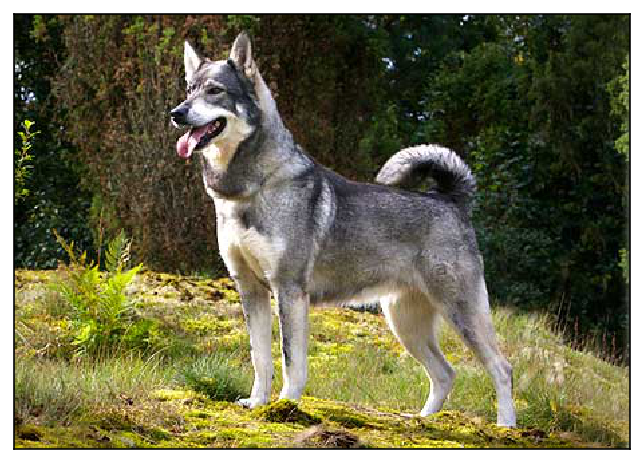

ERROR, no prediction available



NEW IMAGE 


Hello dog and you're a Norwegian elkhound



NEW IMAGE 


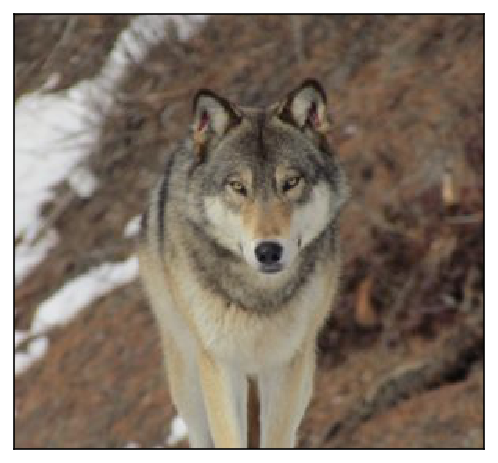

ERROR, no prediction available



NEW IMAGE 


ERROR, no prediction available



NEW IMAGE 


Hello, human!
You look like a ... 
Chinese shar-pei


In [42]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
import glob

for i in glob.iglob('images/*'):
    print("\n\n")
    print("NEW IMAGE ")

    img = Image.open(i)

    imgplot = plt.imshow(img)

    imgplot.axes.get_xaxis().set_visible(False)
    imgplot.axes.get_yaxis().set_visible(False)

    plt.show()

    run_app(i)